# Notebook to review comm's downlink windows and find RFI samples for training and testing

Existing notebooks:
* `ro-comms-overlap.ipynb` identifies overlaps between downlinks and SPIRE dataset samples
* `label_ro_nb.ipynb` (notebook for assigning labels to dataset) + `view_ro_for_labels.ipynb` (notebook for viewin samples from `/scripts/make_label_plots.py` to assign labels)
## Workflow

* make_label_plots for all? downlink samples
* make_label_plots for specific threshold?



In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import os
def load_leo(fn):
    ds = xr.open_dataset(fn, decode_times=False)
    return ds


import sys
 
# adding Folder_2 to the system path
sys.path.insert(0, '/home/stdi2687/gnss-leo-data/scripts')
from feature_extract_util import *

In [2]:
consat_df=pd.read_pickle("../data/consat_df.pkl")

In [3]:
consat_df.head()

,start,end,contact_type,spire_id,G25,G09,G10,G06,G24,G01,...,R12,E30,sum_all,E01,E27,E02,E25,E21,E24,E31
2306,2022-11-02 01:39:25,2022-11-02 01:43:29,CONTACT_RXO,135,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3679,2022-11-03 01:28:00,2022-11-03 01:31:57,CONTACT_BIDIR_UHF,135,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6305,2022-11-06 02:09:27,2022-11-06 02:13:19,CONTACT_RXO,135,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6310,2022-11-06 03:43:22,2022-11-06 03:44:22,CONTACT_RXO,135,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6331,2022-11-06 16:15:24,2022-11-06 16:18:40,CONTACT_RXO,135,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
max_rfi=[]
comms_labels_li=[]

for index, row in consat_df.iloc[:].iterrows():
    start_t=row['start']
    end_t=row['end']
    spireid=row['spire_id']
    contacttype=row['contact_type']
    #gnssid=
    row=row.drop('sum_all')
    idx_sv=row.iloc[4:].gt(0)
    for idx,val in row.iloc[4:][idx_sv].iteritems():
        #print(idx, val)
        gnssid=idx
        
        sample='%s.%03d.%s.%02d.01.%s.SC001_0001' %(start_t.year,start_t.day_of_year,spireid, start_t.hour,gnssid)
        #sample='2023.144.103.01.01.E33.SC001_0001'
        fn1='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
        #either 01 or 02
        if not os.path.isfile(fn1):
            sample='%s.%03d.%s.%02d.02.%s.SC001_0001' %(start_t.year,start_t.day_of_year,spireid, start_t.hour,gnssid)
        
        fn1='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
        fn2='/media/datastore/mirror/spwxdp/repro4/spire/level2/scnLv2/%s/scnLv2_%s.0001_nc'%(sample[:8],sample)
        
        try:
            lv1=xr.open_dataset(fn1, decode_times=False)
            if 'RFI' in list(lv1):
                if np.max(lv1.RFI.values)>.06:
                    lv2=xr.open_mfdataset(fn2, decode_times=False)

                    max_rfi.append(np.max(lv1.RFI.values))
                
                    print(sample, ":", np.max(lv1.RFI.values))

                    fdf=extract_fs(lv1,lv2)
                    plot_leo_feat_RFI(sample, lv1,lv2,fdf)
                    fdf.to_pickle('../data/feature_sets/%s.pkl' %sample)
                    comms_labels_li+=[sample]
                    
                    
                #print(index,fn)
                #lv2=load_leo(fn)

    
        except Exception as ex:
            print(ex)
            #print(file_n)

# Save dataframe of samples created
li_ln=len(comms_labels_li)
converted_labels_comms_dict={"Filename":comms_labels_li, "Approx time (s)":np.full(li_ln, np.nan) ,	
 "Label":np.full(li_ln, "Comms RFI") ,	"Unnamed: 4":np.full(li_ln, np.nan) ,	
 "Unnamed: 5":np.full(li_ln, np.nan) ,	"labeled?":np.full(li_ln, False) }

converted_labels_comms_df=pd.DataFrame(converted_labels_comms_dict)
converted_labels_comms_df.to_pickle('../data/converted_labels_comms.pkl')

2022.321.135.22.01.G24.SC001_0001 : 0.060878847
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2022.336/scnPhs_2022.336.135.04.02.G10.SC001_0001.0001_nc'
2022.338.135.19.01.G31.SC001_0001 : 0.09308802
2022.339.135.19.01.G31.SC001_0001 : 0.06736783
2022.351.135.20.01.G29.SC001_0001 : 0.077491865
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2022.352/scnPhs_2022.352.135.20.02.R18.SC001_0001.0001_nc'
2022.357.135.20.01.G05.SC001_0001 : 0.068554886
2022.357.135.20.01.G29.SC001_0001 : 0.07469181
2022.357.135.20.01.G26.SC001_0001 : 0.06762635
2022.358.135.19.01.G05.SC001_0001 : 0.06258437
2022.358.135.19.01.G26.SC001_0001 : 0.06258437
2022.358.135.22.02.G07.SC001_0001 : 0.060357302
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2022.360/scnPhs_2022.360.135.20.02.G09.SC001_0001.0001_nc'
2023.001.135.20.02.G24.SC001_0001 : 0.061521247
2023.004.1

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nan

2022.363.134.21.01.G12.SC001_0001 : 0.06888561


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


2022.365.134.06.01.G24.SC001_0001 : 0.09134872
2023.009.134.22.01.R18.SC001_0001 : 0.069390304


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-pac

[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.013/scnPhs_2023.013.134.06.02.G24.SC001_0001.0001_nc'
2023.016.134.20.01.G18.SC001_0001 : 0.061042216
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.019/scnPhs_2023.019.134.09.02.G01.SC001_0001.0001_nc'
2023.027.134.20.02.G08.SC001_0001 : 0.065926
2023.031.134.19.01.G03.SC001_0001 : 0.06763557


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nan

2023.032.134.10.02.G09.SC001_0001 : 0.09714301
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.035/scnPhs_2023.035.134.18.02.G09.SC001_0001.0001_nc'
2023.055.134.09.02.G09.SC001_0001 : 0.08356572


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nan

[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.093/scnPhs_2023.093.134.22.02.G11.SC001_0001.0001_nc'
2023.096.134.10.02.G08.SC001_0001 : 0.07269926
2023.098.134.21.02.G29.SC001_0001 : 0.085715495
2023.101.134.09.01.G25.SC001_0001 : 0.08980266
2023.104.134.09.02.G08.SC001_0001 : 0.06005584


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


2023.117.134.09.02.G08.SC001_0001 : 0.06669518


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nan

2023.117.134.12.01.G05.SC001_0001 : 0.06886045
2023.119.134.13.01.G23.SC001_0001 : 0.064067766


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


2023.119.134.13.01.G23.SC001_0001 : 0.064067766


/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2022.344/scnPhs_2022.344.113.22.02.G30.SC001_0001.0001_nc'
2023.015.113.22.01.G32.SC001_0001 : 0.07490505
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2022.335/scnPhs_2022.335.117.20.02.R12.SC001_0001.0001_nc'
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.044/scnPhs_2023.044.117.13.02.G04.SC001_0001.0001_nc'
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.048/scnPhs_2023.048.117.10.02.G11.SC001_0001.0001_nc'
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.069/scnPhs_2023.069.117.22.02.G01.SC001_0001.0001_nc'
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.097/scnPhs_2023.097.117.10.02.G26.SC001_0001.0001_nc'
[Errno 2] No such

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-pac

[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.010/scnPhs_2023.010.163.23.02.G10.SC001_0001.0001_nc'
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.010/scnPhs_2023.010.163.23.02.G11.SC001_0001.0001_nc'
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.010/scnPhs_2023.010.163.23.02.G10.SC001_0001.0001_nc'
2023.013.163.13.01.G32.SC001_0001 : 0.06548055
2023.041.163.01.01.G27.SC001_0001 : 0.063667
2023.041.163.01.01.G15.SC001_0001 : 0.063667
2023.057.163.13.01.G26.SC001_0001 : 0.061653424
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/2023.057/scnPhs_2023.057.163.16.02.G07.SC001_0001.0001_nc'
2023.085.163.00.01.G30.SC001_0001 : 0.06374019
2023.085.163.00.01.G30.SC001_0001 : 0.06374019
[Errno 2] No such file or directory: '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/

In [5]:
converted_labels_comms_df2=pd.read_pickle('../data/converted_labels_comms.pkl')

In [6]:
converted_labels_comms_df2

,Filename,Approx time (s),Label,Unnamed: 4,Unnamed: 5,labeled?
0,2022.321.135.22.01.G24.SC001_0001,NaN,Comms RFI,NaN,NaN,False
1,2022.338.135.19.01.G31.SC001_0001,NaN,Comms RFI,NaN,NaN,False
2,2022.339.135.19.01.G31.SC001_0001,NaN,Comms RFI,NaN,NaN,False
3,2022.351.135.20.01.G29.SC001_0001,NaN,Comms RFI,NaN,NaN,False
4,2022.357.135.20.01.G05.SC001_0001,NaN,Comms RFI,NaN,NaN,False
...,...,...,...,...,...,...
76,2023.096.163.12.02.G01.SC001_0001,NaN,Comms RFI,NaN,NaN,False
77,2023.096.163.12.01.G29.SC001_0001,NaN,Comms RFI,NaN,NaN,False
78,2023.102.163.23.01.G24.SC001_0001,NaN,Comms RFI,NaN,NaN,False
79,2023.102.163.23.01.G24.SC001_0001,NaN,Comms RFI,NaN,NaN,False


In [ ]:
comms_labels_li

['2022.321.135.22.01.G24.SC001_0001',
 '2022.338.135.19.01.G31.SC001_0001',
 '2022.339.135.19.01.G31.SC001_0001']

In [ ]:
li_ln=len(comms_labels_li)
converted_labels_comms_dict={"Filename":comms_labels_li, "Approx time (s)":np.full(li_ln, np.nan) ,	
 "Label":np.full(li_ln, "Comms RFI") ,	"Unnamed: 4":np.full(li_ln, np.nan) ,	"Unnamed: 5":np.full(li_ln, np.nan) ,	"labeled?":np.full(li_ln, False) }

In [ ]:
pd.DataFrame(converted_labels_comms_dict)

,Filename,Approx time (s),Label,Unnamed: 4,Unnamed: 5,labeled?
0,2022.321.135.22.01.G24.SC001_0001,NaN,Comms RFI,NaN,NaN,False
1,2022.338.135.19.01.G31.SC001_0001,NaN,Comms RFI,NaN,NaN,False
2,2022.339.135.19.01.G31.SC001_0001,NaN,Comms RFI,NaN,NaN,False


In [ ]:
lv1

<xarray.Dataset>
Dimensions:    (attribute_dimension: 1, orbtime: 302, time: 15014)
Coordinates:
  * time       (time) float64 7.004 7.024 7.044 7.064 ... 307.2 307.2 307.3
  * orbtime    (orbtime) float64 1.352e+09 1.352e+09 ... 1.352e+09 1.352e+09
Dimensions without coordinates: attribute_dimension
Data variables: (12/20)
    caL1Snr    (time) float64 ...
    pL2Snr     (time) float64 ...
    txmitLR    (orbtime) float64 ...
    xLeoLR     (orbtime) float64 ...
    yLeoLR     (orbtime) float64 ...
    zLeoLR     (orbtime) float64 ...
    ...         ...
    RFI        (orbtime) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    startTime  (attribute_dimension) float64 ...
    stopTime   (attribute_dimension) float64 ...
    gast1      (attribute_dimension) float64 ...
    gast2      (attribute_dimension) float64 ...
    leapsec    (attribute_dimension) float64 ...
Attributes: (12/37)
    year:              2022.0
    month:             11.0
    day:               8.0
    hour:              23.0
    minute:            45.0
    second:            30.01015067100525
    ...                ...
    scnfreq2:          1227600000.0
    scnversion:        3.0
    bitstatus1:        0.0
    bitstatus2:        2.0
    freq1:             L1C
    freq2:             L2L

In [ ]:
%%time
sample='2022.321.135.22.01.G24.SC001_0001'
fn1='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
lv1=xr.open_dataset(fn1, decode_times=False)

CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 10.5 ms


In [ ]:
%%time
if 'RFI' in list(lv1):
    if np.max(lv1.RFI.values)>.06:
        print('rfi')

rfi
CPU times: user 1.31 ms, sys: 3.4 ms, total: 4.71 ms
Wall time: 3.85 ms


In [ ]:
lv2

NameError: name 'lv2' is not defined

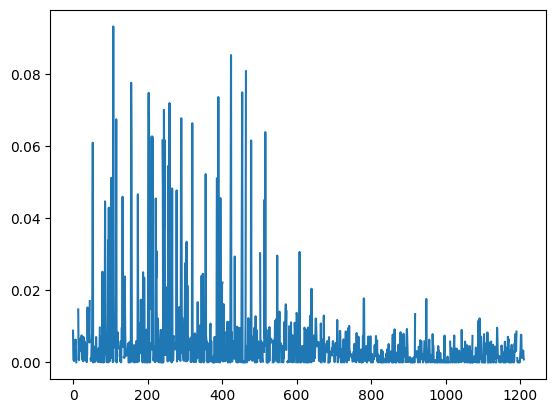

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(max_rfi))

In [ ]:
label_df=pd.read_pickle('../data/converted_labels.pkl')
label_df_t=label_df[label_df["labeled?"]==True]

In [ ]:
label_df_t

,Filename,Approx time (s),Label,Unnamed: 4,Unnamed: 5,labeled?
0,scnPhs_2023.144.103.01.01.E33.SC001_0001.0001_nc,NaN,a/l,NaN,a,True
1,scnPhs_2023.144.103.01.01.G10.SC001_0001.0001_nc,NaN,l,NaN,l,True
2,scnPhs_2023.144.103.01.01.G25.SC001_0001.0001_nc,1.29,ie,sporadic E,ie,True
3,scnPhs_2023.144.103.01.01.G26.SC001_0001.0001_nc,1.48,ie,sporadic E,ie,True
4,scnPhs_2023.144.103.01.01.G27.SC001_0001.0001_nc,NaN,l,NaN,l,True
...,...,...,...,...,...,...
499,scnPhs_2023.144.125.01.02.G01.SC001_0001.0001_nc,NaN,NaN,NaN,NaN,True
500,scnPhs_2023.144.125.01.02.G03.SC001_0001.0001_nc,1.415,ie,NaN,ie,True
501,scnPhs_2023.144.125.01.02.G06.SC001_0001.0001_nc,NaN,NaN,NaN,NaN,True
502,scnPhs_2023.144.125.01.02.G09.SC001_0001.0001_nc,1.505,ie,NaN,ie,True
